# Fig06_AnvileCloud
    Author: Andreas Prein
    E-mail: prein@ucar.edu
    Date created: 23.12.2019
    Date last modified: 23.12.2019

    ##############################################################
    Purpos:

    1) Calculate spatial properties and plot spatial properties of one case

    2) Read in and plot anvile cloud properties from
    
    /glade/u/home/prein/papers/Idealized-MCSs/programs/IceCloud/IceCloudProperties.py

In [1]:
from dateutil import rrule
import datetime
import glob
from netCDF4 import Dataset
import sys, traceback
import dateutil.parser as dparser
import string
from pdb import set_trace as stop
import numpy as np
import numpy.ma as ma
import os
# from mpl_toolkits import basemap
import ESMF
import pickle
import subprocess
import pandas as pd
from scipy import stats
import copy
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib as mpl
import pylab as plt
import random
import scipy.ndimage as ndimage
import matplotlib.gridspec as gridspec
# from mpl_toolkits.basemap import Basemap, cm
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.gridspec as gridspec
from pylab import *
import string
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import shapefile
# import shapely.geometry
# import descartes
import shapefile
import math
from scipy.stats.kde import gaussian_kde
from math import radians, cos, sin, asin, sqrt
from scipy import spatial
import matplotlib.path as mplPath
from pylab import *
from scipy.optimize import curve_fit
import scipy
import math
import SkewT
from scipy.interpolate import interp1d
from thermodynamics import Theta
# from astropy.io import ascii

In [2]:
################################################################################
################################################################################
#                            Settings

rgrGridSpacing=['12000','12000nc','4000','2000','1000','500','250']
rgrDX=[12000,12000,4000,2000,1000,500,250]
sSimDir='/glade/p/mmm/c3we/Idealized_MCSs/data/WRF/'

rgsSimulation=['03_2011-07-16_CTRL_Midwest_-Loc2_MCS_Storm-Nr_JJA-8-TH5']

iEvents=10 # number of events that will be considered

sPlotDir='/glade/u/home/prein/papers/Idealized-MCSs/plots/Fig05_ColdPools/'

rgiDomSize=[51,51,155,311,623,1247,2495]
iOutInt=12 # slizes per hour
ihours=7 # runtime in hours
iSkipH=3 # hours that should be excluded from the simulation
iRadPmax=60000. # m
iRadVol=100000. # m for the volume calculation

Levels=16 # number of model levels that should be read in
rgrDXnative=250

height_v = np.linspace(0,24000-250,96); height_v=height_v/1000.
height_z = np.linspace(125,24000,95); height_z=height_z/1000.
Smooth=12000 # smoothing filter lenth in m

### Load example cloud top temperature field

In [3]:
CTCAll={}
iTT=20
for si in range(len(rgsSimulation)):
    grSimPR={}
    print '    Process '+rgsSimulation[si]
    for dx in range(len(rgrGridSpacing)):
        print '        Process '+rgrGridSpacing[dx]
        iDgc=int(12000./float(rgrDX[dx]))
        iRadGC=int(iRadPmax/float(rgrDX[dx])/2.)+iDgc
        iVolRad=int(iRadVol/float(rgrDX[dx]))
        # read in the precipiation variables
        rgrWact=np.zeros((ihours*iOutInt,rgiDomSize[dx], rgiDomSize[dx])); rgrWact[:]=np.nan
        for hh in [4]: #range(ihours):
            for tt in [8]: #range(iOutInt):
                if rgrGridSpacing[dx] != '250':
                    sFileAct=sSimDir+rgsSimulation[si]+'/'+rgrGridSpacing[dx]+'/wrfout_d01_0001-01-01_'+str("%02d" % hh)+':'+str("%02d" % (tt*5))+':*'
                else:
                    sFileAct=sSimDir+rgsSimulation[si]+'/'+rgrGridSpacing[dx]+'/Combined/wrfout_d01_2000-01-01_'+str("%02d" % hh)+':'+str("%02d" % (tt*5))+':*'
                try:
                    sFileAct=glob.glob(sFileAct)[0]
                    ncid=Dataset(sFileAct, mode='r') # open the netcdf file
                except:
                    stop()
                    
                # Calculate cloud top temperature
                rgrP                = np.squeeze(ncid.variables["PB"][:,:,:,:])+np.squeeze(ncid.variables["P"][:,:,:,:])
                rgrT                = (np.squeeze(ncid.variables["T"][:,:,:,:])+300)* (rgrP/100000.)**0.2854
                rgrSNOW             = np.squeeze(ncid.variables["QSNOW"][:,:,:,:])
                rgrICE              = np.squeeze(ncid.variables["QICE"][:,:,:,:])
                rgrCLOUD            = np.squeeze(ncid.variables["QCLOUD"][:,:,:,:])
                rgrRAIN             = np.squeeze(ncid.variables["QRAIN"][:,:,:,:])
                rgrGRAUP            = np.squeeze(ncid.variables["QGRAUP"][:,:,:,:])
                ncid.close()
                rgrFrozen=(rgrSNOW+rgrICE+rgrCLOUD+rgrRAIN+rgrGRAUP)*1000.
                rgrT[rgrFrozen < 0.1]=np.nan
                rgrTCTact=np.nanmin(rgrT, axis=0)
                    
        CTCAll[str(rgrGridSpacing[dx])+'_W']=rgrTCTact

    Process 03_2011-07-16_CTRL_Midwest_-Loc2_MCS_Storm-Nr_JJA-8-TH5
        Process 12000
        Process 12000nc


/gpfs/u/apps/dav/opt/python/2.7.14/intel/17.0.1/pkg-library/20180510/lib/python2.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered


        Process 4000
        Process 2000
        Process 1000
        Process 500
        Process 250


## Load mean cloud top temperature statistics

In [13]:
rgrGridSpacing=['12000','12000nc','4000','2000','1000','500','250']
rgsDXcol=['#1f78b4','#6a3d9a','#33a02c','#b2df8a','#fdbf6f','#ff7f00','#e31a1c']
sGrid='12km'  # can be 'native' for native grid or '12km' for 12 km model grid
rgrDX=[12000,12000,4000,2000,1000,500,250]
sDataDir='/glade/scratch/prein/Papers/Idealized_MCSs/data/IceClouds/'+sGrid+'/'

rgsSimulations=['19_2011-07-13_CTRL_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5',
                '03_2011-07-16_CTRL_Midwest_-Loc2_MCS_Storm-Nr_JJA-8-TH5',
                '23_2007-06-19_CTRL_Midwest_-Loc2_MCS_Storm-Nr_JJA-8-TH5',
                '10_2009-06-27_CTRL_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5',
                '13_2003-08-30_CTRL_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5',
                '17_2011-06-27_CTRL_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5',
                '18_2010-06-13_CTRL_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5',
                '38_2007-08-04_CTRL_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5',
                '46_2009-06-14_CTRL_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5',
                '07_2011-07-04_CTRL_Midwest_-Loc2_MCS_Storm-Nr_JJA-8-TH5']#,

#                 '64_2012-06-17_PGW_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5',
#                 '58_2009-06-08_PGW_Midwest_-Loc2_MCS_Storm-Nr_JJA-8-TH5',
#                 '41_2005-06-10_PGW_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5',
#                 '68_2013-07-07_PGW_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5',
#                 '31_2006-08-18_PGW_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5',
#                 '16_2002-06-11_PGW_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5',
#                 '34_2010-07-12_PGW_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5',
#                 '51_2003-06-23_PGW_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5',
#                 '56_2008-06-18_PGW_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5',
#                 '35_2004-07-02_PGW_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5']

iEvents=10 # number of events that will be considered

sPlotDir='/glade/u/home/prein/papers/Idealized-MCSs/plots/IceClouds/'

rgiDomSize=[51,51,155,311,623,1247,2495]
ihours=7 # runtime in hours

Cloud_area=np.zeros((85,len(rgsSimulations),len(rgrGridSpacing))); Cloud_area[:]=np.nan
T_CT_mean=np.copy(Cloud_area)
T_CT_max=np.copy(Cloud_area)
CTH_mean=np.copy(Cloud_area)
CTH_max=np.copy(Cloud_area)

for si in range(len(rgsSimulations)):
    print '    Load '+rgsSimulations[si]
    grDATA={}
    for dx in range(len(rgrGridSpacing)):
        try:
            fname=sDataDir+rgsSimulations[si]+'_'+rgrGridSpacing[dx]+'m.pkl'
            dbfile = open(fname, 'rb')
            DATA=pickle.load(dbfile)
            T_CT_mean[:,si,dx]=DATA['TS'][:,0]
            T_CT_max[:,si,dx]=DATA['TS'][:,1]
            CTH_mean[:,si,dx]=DATA['CTH'][:,0]
            CTH_max[:,si,dx]=DATA['CTH'][:,1]
            Cloud_area[:,si,dx]=DATA['IceCloud_HE']
            # replace zero with nan
            Cloud_area[Cloud_area == 0]=np.nan
            T_CT_mean[T_CT_mean == 0]=np.nan
            T_CT_max[T_CT_max == 0]=np.nan
            CTH_mean[CTH_mean == 0]=np.nan
            CTH_max[CTH_max == 0]=np.nan
        except:
            continue

    Load 19_2011-07-13_CTRL_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5
    Load 03_2011-07-16_CTRL_Midwest_-Loc2_MCS_Storm-Nr_JJA-8-TH5
    Load 23_2007-06-19_CTRL_Midwest_-Loc2_MCS_Storm-Nr_JJA-8-TH5
    Load 10_2009-06-27_CTRL_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5
    Load 13_2003-08-30_CTRL_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5
    Load 17_2011-06-27_CTRL_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5
    Load 18_2010-06-13_CTRL_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5
    Load 38_2007-08-04_CTRL_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5
    Load 46_2009-06-14_CTRL_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5
    Load 07_2011-07-04_CTRL_Midwest_-Loc2_MCS_Storm-Nr_JJA-8-TH5


## Plotting

/gpfs/u/apps/dav/opt/python/2.7.14/intel/17.0.1/pkg-library/20180510/lib/python2.7/site-packages/ipykernel_launcher.py:117: RuntimeWarning: Mean of empty slice


        Plot map to: /glade/u/home/prein/papers/Idealized-MCSs/plots/IceClouds/Fig06_AnvileCloudCharacteristics_temperature.pdf
        Plot map to: /glade/u/home/prein/papers/Idealized-MCSs/plots/IceClouds/Fig06_AnvileCloudCharacteristics_height.pdf


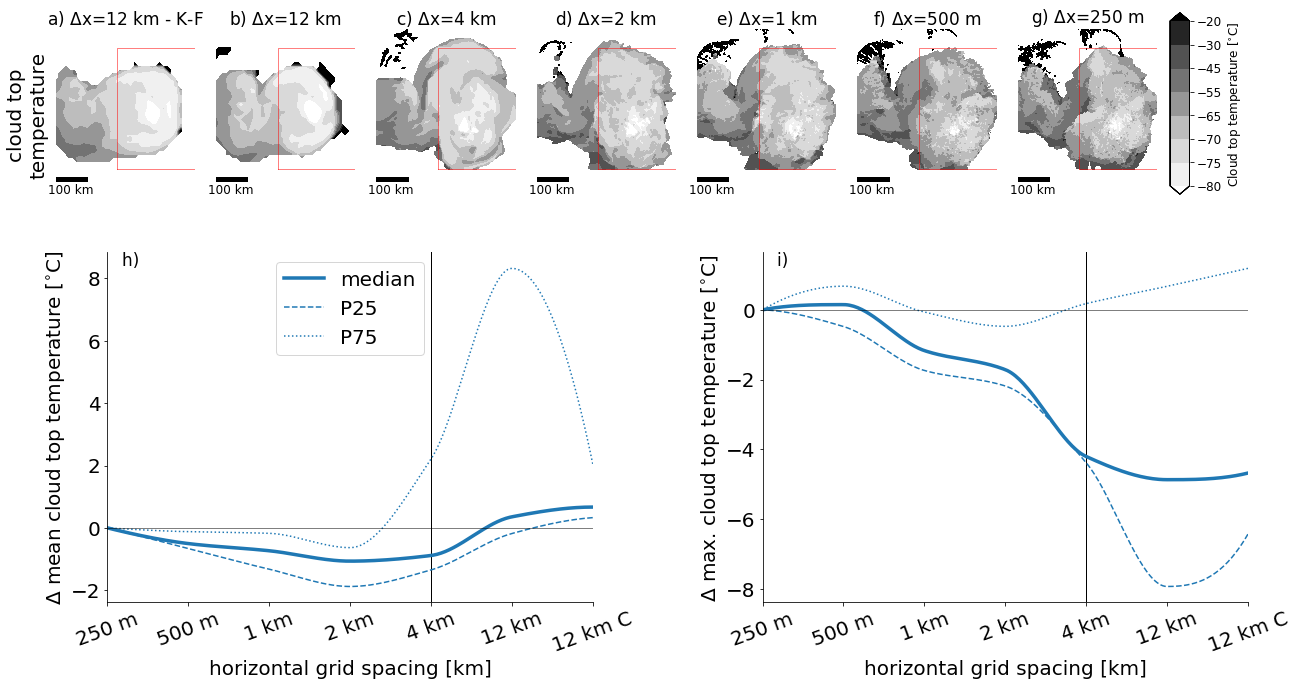

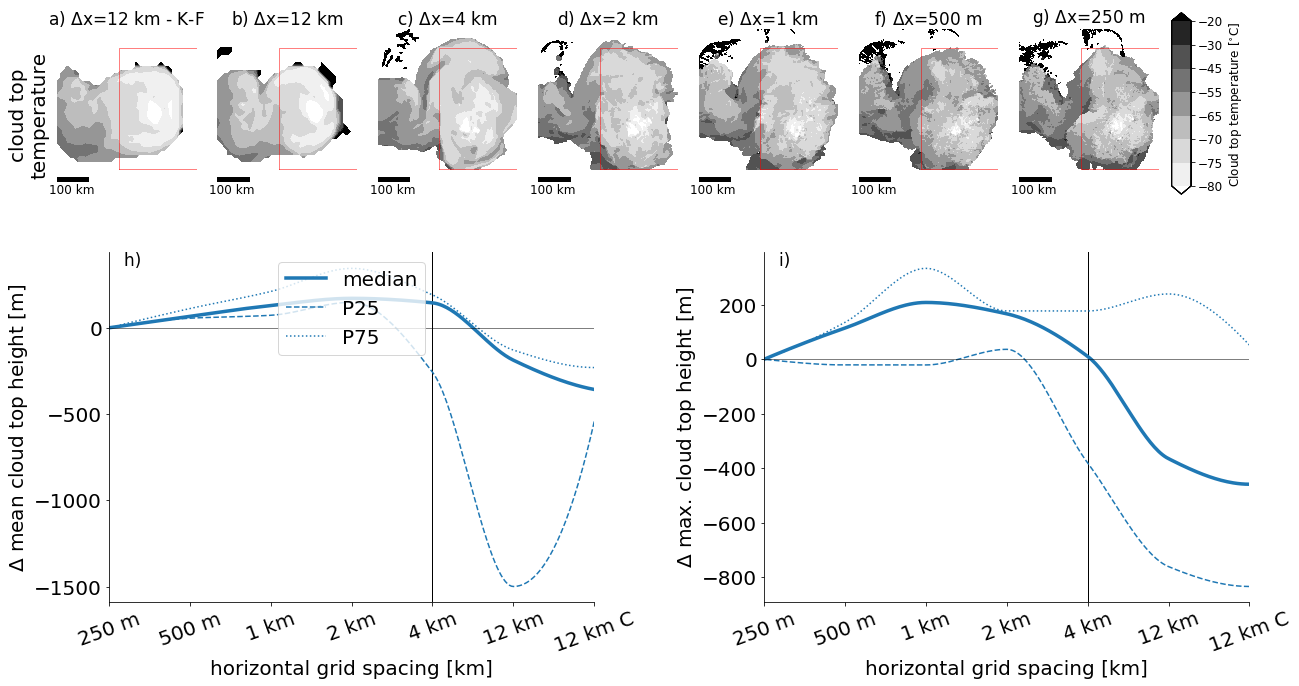

In [20]:
Stats=['temperature','height']
for pl in range(len(Stats)):
    if Stats[pl] == 'temperature':
        DATAmean=T_CT_mean
        DATAmax=T_CT_max
        Unit='$^{\circ}$C'
    if Stats[pl] == 'height':
        DATAmean=CTH_mean
        DATAmax=CTH_max
        Unit='m'

    # set the font size
    plt.rcParams.update({'font.size': 15})
    rgsLableABC=list(string.ascii_lowercase)

    fig = plt.figure(figsize=(18,9))
    plt.rcParams.update({'font.size': 20})
    gs1 = gridspec.GridSpec(1,len(rgrGridSpacing))
    gs1.update(left=0.05, right=0.9,
               bottom=0.70, top=0.965,
               wspace=0.15, hspace=0.3)

    nws_W_colors = ['#fff7fb','#ece7f2','#d0d1e6','#a6bddb','#74a9cf','#3690c0','#0570b0','#045a8d','#023858']
    cStep=4.
    levelsW = (np.array(range(len(nws_W_colors)+1))/float(len(nws_W_colors)))*cStep*len(nws_W_colors)

    for dx in range(len(rgrGridSpacing)):
        rgrWact=CTCAll[str(rgrGridSpacing[dx])+'_W']-273.15
        iSmooth=int(Smooth/rgrDX[dx])
        CPint_smooth=scipy.ndimage.uniform_filter(rgrWact,[iSmooth,iSmooth])

        rgrAxis=np.linspace(0,rgrWact.shape[0]*float(rgrDX[dx]),rgrWact.shape[0])/1000.
        ax = plt.subplot(gs1[0,dx])
        ax.axis('off')
        if dx == 0:
            ax.text(-0.2,0.5, 'cloud top\ntemperature', ha='center', va='center', fontsize=20,transform = ax.transAxes, rotation=90) #, fontweight='bold')
        # plt CTT
        Colors=['#ffffff','#f0f0f0','#d9d9d9','#bdbdbd','#969696','#737373','#525252','#252525','#000000']
        CYYLevels=[-80,-75,-70,-65,-55,-45,-30,-20]
        cs = ax.contourf(rgrAxis, rgrAxis,rgrWact, levels=CYYLevels, colors=Colors, extend='both',zorder = 1)
        sCBlabel='Cloud Top Temperature [$^{\circ}$]' 
        TicksCB=CYYLevels #[-80,-75,-70,-65,-60,-55,-50]
        cs = ax.contourf(rgrAxis, rgrAxis,rgrWact, levels=CYYLevels, colors=Colors, extend='both',zorder = 1)
    #     ax.contour(rgrAxis, rgrAxis, CPint_smooth, levels=[0,10,10000], colors=['r','r','r'], linewidths=0.5)
    #     cs.cmap.set_over('#023858')  
        sCBlabel='Cloud top temperature [$^{\circ}$C]' 
        TicksCB=levelsW

        # plot a line for scale reference
        ax.plot([50,150],[-30,-30],lw=5, c='k')
        ax.text(100,-45,'100 km', ha='center', va='top', fontsize=12)

        if rgrGridSpacing[dx] == '250':
            ax.text(0.5,1, rgsLableABC[dx]+') $\Delta$x='+str(250)+' m', ha='center', va='bottom', 
                    fontsize=17,transform = ax.transAxes) #, fontweight='bold')
        elif rgrGridSpacing[dx] == '500':
            ax.text(0.5,1, rgsLableABC[dx]+') $\Delta$x='+str(500)+' m', ha='center', va='bottom', 
                    fontsize=17,transform = ax.transAxes) #, fontweight='bold')
        else:
            if rgrGridSpacing[dx] == '12000':
                # use of cumulus scheme
                ax.text(0.5,1,rgsLableABC[dx]+') $\Delta$x='+str(int(float(rgrDX[dx])/1000.))+' km - K-F', ha='center', va='bottom', 
                        fontsize=17,transform = ax.transAxes) #, fontweight='bold')
            else:
                ax.text(0.5,1,rgsLableABC[dx]+') $\Delta$x='+str(int(float(rgrDX[dx])/1000.))+' km', ha='center', va='bottom', 
                        fontsize=17,transform = ax.transAxes) #, fontweight='bold')
        plt.grid()
        ax.set_ylim([-100,450])
        ax.set_xlim([50,525])
        ax.axis('off')     

        # plot box of area that is shown in previous plots
        ax.plot([260,260,650,650,260], [0,390,390,0,0], c='r', lw=0.5)

        # add colorbar
        pos1 = ax.get_position()
        CbarAx = axes([0.91,0.71, 0.015, 0.28])
        cb = colorbar(cs, cax = CbarAx, orientation='vertical', extend='max', ticks=CYYLevels) #, ticks=np.linspace(0,120,13))
        cb.set_label(label=sCBlabel,size=12)
        cb.ax.tick_params(labelsize=12)



    # ===========================
    # Plot ensamble evaluation
    gs1 = gridspec.GridSpec(1,2)
    gs1.update(left=0.09, right=0.97,
               bottom=0.08, top=0.62,
               wspace=0.35, hspace=0.35)

    rgsColors=['k','#e31a1c']
    rgsPeriods=['CUR','FUT']
    rgsStatsSel=['cloud top mean '+Stats[pl]+' ['+Unit+']', 'cloud top max. '+Stats[pl]+' ['+Unit+']']

    col='#1f78b4'
    for st in range(len(rgsStatsSel)):
        ax = plt.subplot(gs1[0,st])
        if rgsStatsSel[st] == 'anvile extent [km$^2$]':
            DATA=Cloud_area
            Yrange=[-80,10]
            Label='$\Delta$ anvile area [%]'
        if rgsStatsSel[st] == 'cloud top mean '+Stats[pl]+' ['+Unit+']':
            DATA=DATAmean
            Yrange=[-5,8]
            Label='$\Delta$ mean cloud top '+Stats[pl]+' ['+Unit+']'
        if rgsStatsSel[st] == 'cloud top max. '+Stats[pl]+' ['+Unit+']':
            DATA=DATAmax
            Yrange=[-10,4]
            Label='$\Delta$ max. cloud top '+Stats[pl]+' ['+Unit+']'

        Xaxis=np.round(np.arange(0,len(rgrGridSpacing)+0.025,0.025),3)
        RealPoints = [np.where(Xaxis == ii)[0][0] for ii in range(len(rgrDX))]
        DATA_pe=DATA[12*3:12*5,:10,:]
        if rgsStatsSel[st] == 'anvile extent [km$^2$]':
            Data_Diff=np.nanmean((DATA_pe[:,:,:]-DATA_pe[:,:,-1][:,:,None])/DATA_pe[:,:,-1][:,:,None], axis=0)*100.
        else:
            Data_Diff=np.nanmean((DATA_pe[:,:,:]-DATA_pe[:,:,-1][:,:,None]), axis=0)

        # median
        DataInt=np.copy(Xaxis); DataInt[:]=np.nan; DataInt[RealPoints[:]]=np.nanmedian(Data_Diff, axis=0)
        s = pd.Series(DataInt)
        plt.plot(Xaxis[::-1], s.interpolate(method='pchip'), c=col, lw=3.5, alpha=1, label='median')

        # plot P25-P75
        P25=np.copy(Xaxis); P25[:]=np.nan; P25[RealPoints[:]]=np.nanpercentile(Data_Diff, 25, axis=0)
        s25 = pd.Series(P25)
        ax.plot(Xaxis[::-1],s25.interpolate(method='pchip'), c=col, ls='--', label='P25')
        P75=np.copy(Xaxis); P75[:]=np.nan; P75[RealPoints[:]]=np.nanpercentile(Data_Diff, 75, axis=0)
        s75 = pd.Series(P75)
        ax.plot(Xaxis[::-1],s75.interpolate(method='pchip'), c=col, ls=':', label='P75')

        labels = np.array([ '12 km C',  '12 km',  '4 km', '2 km','1 km','500 m', '250 m'])
        # for dx in range(len(xx)):
        #     ax.axvline(x=xx[dx], ls='--', c='k', zorder=-1, alpha=0.6, lw=0.2)
        #     ax.text(xx[dx],Yrange[ud][0], labels[dx], ha='left',va='bottom', \
        #             fontname="Times New Roman Bold", fontsize=9, rotation=90)

        xx = (np.array([0.5,1.5, 2.5, 3.5,4.5,5.5,6.5])+0.5)[::-1]
        labels = np.array([ '12 km C',  '12 km',  '4 km', '2 km','1 km','500 m', '250 m'])
        plt.xticks(xx, labels, rotation=20)
        ax.get_xaxis().get_major_formatter().labelOnlyBase = False

        ax.set_ylabel(Label)
        ax.set_xlabel('horizontal grid spacing [km]')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.set_xlim(1, 7)
        plt.axhline(y=0, c='k', lw=0.5)
#         plt.ylim(Yrange[0],Yrange[1])
        ax.axvline(x=5, ls='-', c='k', zorder=-1, alpha=1, lw=1)

        if (st == 0):
            plt.legend(loc="upper center",
                       ncol=1, prop={'size':20})
        ax.text(0.03,0.95, rgsLableABC[st+7]+') ', ha='left',va='bottom', \
                transform = ax.transAxes, fontname="Times New Roman Bold", fontsize=17)


    # Plot the figure
    sPlotFile=sPlotDir
    sPlotName= 'Fig06_AnvileCloudCharacteristics_'+Stats[pl]+'.pdf'
    if os.path.isdir(sPlotFile) != 1:
        subprocess.call(["mkdir","-p",sPlotFile])
    print '        Plot map to: '+sPlotFile+sPlotName
    fig.savefig(sPlotFile+sPlotName)

In [7]:
DATA_pe.shape

(73, 10, 7)